In [1]:
from river.datasets import ImageSegments
from river.preprocessing import MinMaxScaler
from river.tree import HoeffdingTreeClassifier
from deep_river.classification import Classifier
from torch import nn
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import numpy as np
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.utils import resample
from sklearn.manifold import TSNE

random.seed(0)

### Create Stream

In [2]:
stream_size = 10_000

x, y = list(zip(*ImageSegments()))
x = np.array(x)
y = np.array(y)

# Divide classes into two task specific sets
task_classes = [
    ["brickface", "window", "cement"],
    ["sky", "foliage", "path", "grass"],
]

# Divide all samples into their specific tasks
data_train = []
data_test = []
for classes_t in task_classes:
    x_t = np.concatenate([x[y == c] for c in classes_t])
    y_t = np.concatenate([330 * [c] for c in classes_t])
    x_train, x_test, y_train, y_test = train_test_split(
        x_t, y_t, test_size=0.25, stratify=y_t
    )
    x_train, y_train = resample(
        x_train, y_train, n_samples=int(stream_size / 2), stratify=y_train
    )
    data_train.append(list(zip(x_train, y_train)))
    data_test.append(list(zip(x_test, y_test)))

data_train = data_train[0] + data_train[1]

### Visualize Data

In [3]:
classnames = task_classes[0] + task_classes[1]
tsne = TSNE(init="pca", learning_rate="auto", n_jobs=-1)
x_array = np.array([list(x_i.values()) for x_i in x])
x_viz = tsne.fit_transform(x_array)

/Users/cedrickulbach/Documents/Environments/deep-river/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


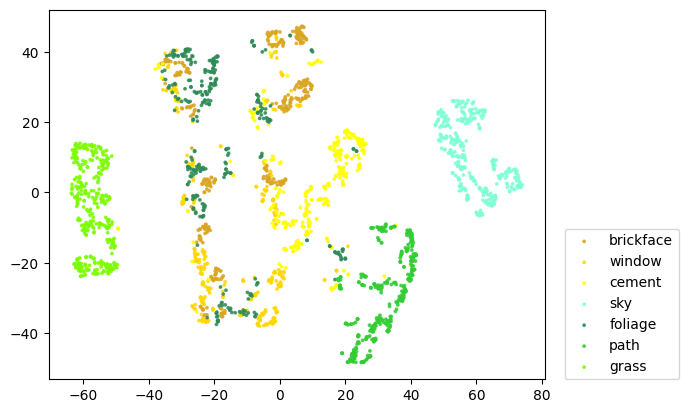

In [4]:
fig, ax = plt.subplots()
cm = [
    "goldenrod",
    "gold",
    "yellow",
    "aquamarine",
    "seagreen",
    "limegreen",
    "lawngreen",
]
for c_idx, x_c in enumerate([x_viz[y == c] for c in classnames]):
    scatter = ax.scatter(
        x_c[:, 0],
        x_c[:, 1],
        c=len(x_c) * [cm[c_idx]],
        s=3,
        alpha=0.8,
        label=classnames[c_idx],
    )

ax.legend(loc=(1.04, 0))

### Define evaluation procedure

In [5]:
# Define function to calculate accuracy on testing data for each task
def get_test_accuracy(model, data_test):
    results = []
    for data_test_i in data_test:
        ys = []
        y_preds = []
        for x_test, y_test in data_test_i:
            ys.append(y_test)
            y_preds.append(model.predict_one(x_test))
        accuracy = accuracy_score(ys, y_preds)
        results.append(accuracy)
    return results


# Define training and testing loop
def eval_separate_testing(model, data_train, data_test):
    scaler = MinMaxScaler()
    step = 0
    steps = []
    results = [[] for task in data_test]
    for x, y in tqdm(data_train):
        step += 1
        scaler.learn_one(x)
        x = scaler.transform_one(x)
        model.learn_one(x, y)

        if step % 100 == 0:
            test_accuracies = get_test_accuracy(model, data_test)
            for idx, accuracy in enumerate(test_accuracies):
                results[idx].append(accuracy)
            steps.append(step)
    return steps, results

## Evaluate Classifiers

In [6]:
# Evaluate a simple MLP classifier
class SimpleMLP(nn.Module):
    def __init__(self, n_features):
        super().__init__()
        self.hidden1 = nn.Linear(n_features, 30)
        self.logits = nn.Linear(30, 7)

    def forward(self, x):
        h = torch.relu(self.hidden1(x))
        return self.logits(h)


mlp = Classifier(
    SimpleMLP,
    loss_fn="binary_cross_entropy_with_logits",
    optimizer_fn="sgd",
    lr=0.05,
    seed=42,
)
steps, results_mlp = eval_separate_testing(mlp, data_train, data_test)

  0%|                                                                                                                                                                                    | 0/10000 [00:00<?, ?it/s]

  0%|                                                                                                                                                                          | 1/10000 [00:00<1:49:46,  1.52it/s]

  1%|█▉                                                                                                                                                                       | 113/10000 [00:00<00:49, 200.85it/s]

  3%|████▍                                                                                                                                                                    | 261/10000 [00:00<00:21, 460.40it/s]

  4%|██████▊                                                                                                                                                                  | 400/10000 [00:01<00:15, 611.29it/s]

  5%|█████████▏                                                                                                                                                               | 545/10000 [00:01<00:11, 801.16it/s]

  7%|███████████▊                                                                                                                                                             | 700/10000 [00:01<00:10, 891.74it/s]

  9%|██████████████▌                                                                                                                                                         | 867/10000 [00:01<00:08, 1078.71it/s]

 10%|████████████████▋                                                                                                                                                      | 1000/10000 [00:01<00:08, 1048.10it/s]

 11%|███████████████████                                                                                                                                                    | 1144/10000 [00:01<00:07, 1146.20it/s]

 13%|█████████████████████▋                                                                                                                                                 | 1300/10000 [00:01<00:07, 1145.28it/s]

 14%|████████████████████████                                                                                                                                               | 1443/10000 [00:01<00:07, 1217.90it/s]

 16%|██████████████████████████▋                                                                                                                                            | 1600/10000 [00:01<00:07, 1187.78it/s]

 18%|█████████████████████████████▎                                                                                                                                         | 1754/10000 [00:02<00:06, 1278.29it/s]

 19%|███████████████████████████████▋                                                                                                                                       | 1900/10000 [00:02<00:06, 1208.64it/s]

 20%|██████████████████████████████████▏                                                                                                                                    | 2045/10000 [00:02<00:06, 1270.02it/s]

 22%|████████████████████████████████████▋                                                                                                                                  | 2200/10000 [00:02<00:06, 1213.71it/s]

 24%|███████████████████████████████████████▎                                                                                                                               | 2357/10000 [00:02<00:05, 1305.30it/s]

 25%|█████████████████████████████████████████▊                                                                                                                             | 2500/10000 [00:02<00:06, 1200.96it/s]

 27%|████████████████████████████████████████████▍                                                                                                                          | 2663/10000 [00:02<00:05, 1310.59it/s]

 28%|██████████████████████████████████████████████▊                                                                                                                        | 2800/10000 [00:02<00:06, 1190.89it/s]

 29%|█████████████████████████████████████████████████                                                                                                                      | 2938/10000 [00:03<00:05, 1238.83it/s]

 31%|███████████████████████████████████████████████████▋                                                                                                                   | 3098/10000 [00:03<00:05, 1334.76it/s]

 32%|██████████████████████████████████████████████████████                                                                                                                 | 3236/10000 [00:03<00:05, 1211.38it/s]

 34%|████████████████████████████████████████████████████████▋                                                                                                              | 3397/10000 [00:03<00:05, 1314.96it/s]

 35%|███████████████████████████████████████████████████████████                                                                                                            | 3534/10000 [00:03<00:05, 1226.40it/s]

 37%|█████████████████████████████████████████████████████████████▌                                                                                                         | 3683/10000 [00:03<00:04, 1295.19it/s]

 38%|███████████████████████████████████████████████████████████████▋                                                                                                       | 3817/10000 [00:03<00:05, 1192.81it/s]

 40%|██████████████████████████████████████████████████████████████████▌                                                                                                    | 3984/10000 [00:03<00:04, 1317.97it/s]

 41%|████████████████████████████████████████████████████████████████████▊                                                                                                  | 4121/10000 [00:03<00:04, 1223.27it/s]

 43%|███████████████████████████████████████████████████████████████████████▏                                                                                               | 4260/10000 [00:04<00:04, 1266.64it/s]

 44%|█████████████████████████████████████████████████████████████████████████▍                                                                                             | 4400/10000 [00:04<00:04, 1171.50it/s]

 46%|████████████████████████████████████████████████████████████████████████████▏                                                                                          | 4562/10000 [00:04<00:04, 1287.95it/s]

 47%|██████████████████████████████████████████████████████████████████████████████▍                                                                                        | 4700/10000 [00:04<00:04, 1210.46it/s]

 49%|█████████████████████████████████████████████████████████████████████████████████▏                                                                                     | 4862/10000 [00:04<00:03, 1317.20it/s]

 50%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 5000/10000 [00:04<00:04, 1224.42it/s]

 52%|██████████████████████████████████████████████████████████████████████████████████████▍                                                                                | 5175/10000 [00:04<00:03, 1361.84it/s]

 53%|████████████████████████████████████████████████████████████████████████████████████████▊                                                                              | 5316/10000 [00:04<00:03, 1277.47it/s]

 55%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                           | 5491/10000 [00:04<00:03, 1402.16it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                         | 5636/10000 [00:05<00:03, 1311.82it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 5790/10000 [00:05<00:03, 1371.64it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 5931/10000 [00:05<00:03, 1286.43it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 6100/10000 [00:05<00:03, 1270.99it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 6275/10000 [00:05<00:02, 1393.84it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 6418/10000 [00:05<00:02, 1311.01it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 6583/10000 [00:05<00:02, 1400.70it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 6727/10000 [00:05<00:02, 1323.09it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 6900/10000 [00:06<00:02, 1304.55it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 7047/10000 [00:06<00:02, 1346.98it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 7200/10000 [00:06<00:02, 1265.46it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 7354/10000 [00:06<00:01, 1336.48it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 7500/10000 [00:06<00:01, 1258.33it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 7664/10000 [00:06<00:01, 1357.71it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 7804/10000 [00:06<00:01, 1262.73it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 7977/10000 [00:06<00:01, 1385.16it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 8120/10000 [00:07<00:01, 1280.37it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 8278/10000 [00:07<00:01, 1358.76it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 8418/10000 [00:07<00:01, 1250.15it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 8582/10000 [00:07<00:01, 1351.48it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 8722/10000 [00:07<00:01, 1277.55it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 8876/10000 [00:07<00:00, 1347.13it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 9014/10000 [00:07<00:00, 1234.06it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 9159/10000 [00:07<00:00, 1290.18it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 9300/10000 [00:07<00:00, 1213.86it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 9473/10000 [00:08<00:00, 1349.18it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 9612/10000 [00:08<00:00, 1275.18it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 9764/10000 [00:08<00:00, 1340.78it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 9902/10000 [00:08<00:00, 1251.34it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1181.24it/s]

In [7]:
# Evaluate a Hoeffding Tree classifier
tree = HoeffdingTreeClassifier(tau=0.05)
steps, results_tree = eval_separate_testing(tree, data_train, data_test)

  0%|                                                                                                                                                                                    | 0/10000 [00:00<?, ?it/s]

  3%|████▉                                                                                                                                                                   | 297/10000 [00:00<00:03, 2968.49it/s]

  6%|█████████▉                                                                                                                                                              | 594/10000 [00:00<00:03, 2413.87it/s]

  8%|██████████████▏                                                                                                                                                         | 842/10000 [00:00<00:04, 2128.90it/s]

 11%|██████████████████▎                                                                                                                                                    | 1100/10000 [00:00<00:04, 2070.13it/s]

 14%|███████████████████████▍                                                                                                                                               | 1400/10000 [00:00<00:04, 2127.05it/s]

 16%|███████████████████████████                                                                                                                                            | 1621/10000 [00:00<00:03, 2150.28it/s]

 18%|██████████████████████████████▋                                                                                                                                        | 1838/10000 [00:00<00:03, 2081.45it/s]

 20%|██████████████████████████████████▏                                                                                                                                    | 2047/10000 [00:00<00:03, 2064.48it/s]

 23%|█████████████████████████████████████▋                                                                                                                                 | 2260/10000 [00:01<00:03, 2082.64it/s]

 25%|█████████████████████████████████████████▊                                                                                                                             | 2500/10000 [00:01<00:03, 1996.02it/s]

 28%|██████████████████████████████████████████████                                                                                                                         | 2761/10000 [00:01<00:03, 2165.13it/s]

 30%|█████████████████████████████████████████████████▊                                                                                                                     | 2981/10000 [00:01<00:03, 2168.21it/s]

 32%|█████████████████████████████████████████████████████▍                                                                                                                 | 3200/10000 [00:01<00:03, 1999.85it/s]

 35%|██████████████████████████████████████████████████████████▎                                                                                                            | 3495/10000 [00:01<00:02, 2259.18it/s]

 37%|██████████████████████████████████████████████████████████████▏                                                                                                        | 3726/10000 [00:01<00:02, 2111.72it/s]

 40%|██████████████████████████████████████████████████████████████████▊                                                                                                    | 4000/10000 [00:01<00:02, 2078.82it/s]

 42%|██████████████████████████████████████████████████████████████████████▌                                                                                                | 4226/10000 [00:01<00:02, 2125.63it/s]

 46%|████████████████████████████████████████████████████████████████████████████▊                                                                                          | 4600/10000 [00:02<00:02, 2546.22it/s]

 50%|██████████████████████████████████████████████████████████████████████████████████▉                                                                                    | 4963/10000 [00:02<00:01, 2847.50it/s]

 53%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                               | 5255/10000 [00:02<00:02, 2244.84it/s]

 55%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                                           | 5504/10000 [00:02<00:02, 1794.80it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 5713/10000 [00:02<00:02, 1683.95it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                    | 5901/10000 [00:02<00:02, 1553.68it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 6100/10000 [00:03<00:02, 1499.21it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 6300/10000 [00:03<00:02, 1456.10it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 6500/10000 [00:03<00:02, 1413.42it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 6700/10000 [00:03<00:02, 1377.51it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 6900/10000 [00:03<00:02, 1365.36it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 7100/10000 [00:03<00:02, 1359.98it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 7300/10000 [00:03<00:01, 1357.37it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 7500/10000 [00:04<00:01, 1360.12it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 7700/10000 [00:04<00:01, 1360.79it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 7900/10000 [00:04<00:01, 1349.20it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 8100/10000 [00:04<00:01, 1349.90it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 8300/10000 [00:04<00:01, 1345.24it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 8500/10000 [00:04<00:01, 1349.20it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 8700/10000 [00:04<00:00, 1349.04it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 8900/10000 [00:05<00:00, 1355.18it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 9100/10000 [00:05<00:00, 1342.30it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 9300/10000 [00:05<00:00, 1330.82it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 9500/10000 [00:05<00:00, 1341.23it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 9700/10000 [00:05<00:00, 1333.14it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 9900/10000 [00:05<00:00, 1328.72it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:05<00:00, 1676.92it/s]

### Visualize Accuracy over Timesteps

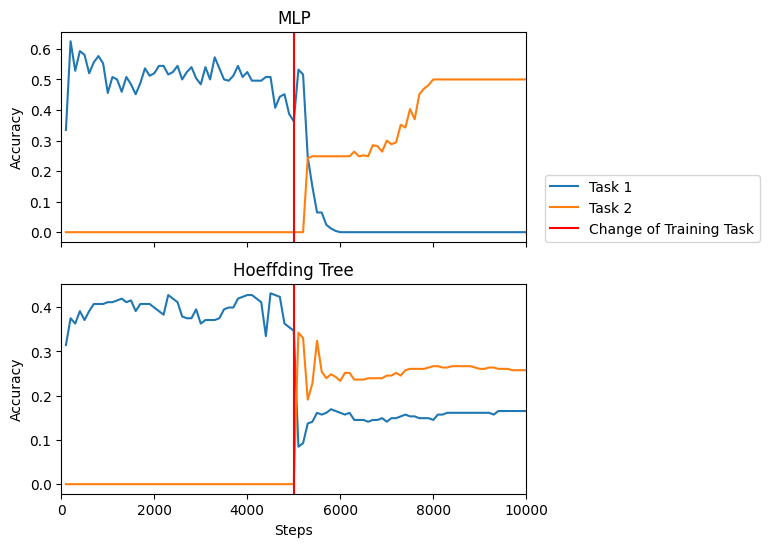

In [8]:
fig, axs = plt.subplots(nrows=2, figsize=(6, 6), sharex=True)
results = {"MLP": results_mlp, "Hoeffding Tree": results_tree}
for model_idx, (model_name, model_results) in enumerate(results.items()):
    ax = axs[model_idx]
    ax.plot(steps, model_results[0], label="Task 1")
    ax.plot(steps, model_results[1], label="Task 2")
    ax.axvline(5000, c="red", label="Change of Training Task")
    ax.set_ylabel("Accuracy")
    ax.set_title(model_name)
axs[-1].set_xlabel("Steps")
axs[-1].set_xlim(0, 10000)
axs[0].legend(loc=(1.04, 0))